In [13]:
# imports
import keras_tuner as kt
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from nnTrain import getSplitData

In [14]:
class HyperTuner(kt.HyperModel):
  def build(self, hp):
    model = Sequential()

    for i in range(hp.Int("num_layers", 3, 9)): # Variable number of hidden layers
      model.add(
        Dense(
          units = hp.Int(f"units_{i}", min_value = 6, max_value = 54, step = 2),
          activation = hp.Choice("activation", ["relu", "elu"])
        )
      )

    if hp.Boolean("dropout"): # Possible dropout layer to prevent overfitting
      model.add(Dropout(rate = hp.Float("dropout_rate", min_value = 0.1, max_value = 0.9, step = 0.1)))

    model.add(Dense(1, activation = "sigmoid")) # Output layer

    learning_rate = hp.Float("lr", min_value = 1e-4, max_value = 1e-2, sampling = "log")

    # Compile the model
    model.compile(
      loss = "binary_crossentropy", optimizer = Adam(learning_rate = learning_rate), metrics = ["accuracy"]
    )

    return model

  def fit(self, hp, model, *args, **kwargs):
    return model.fit(
      *args,
      batch_size = hp.Int("batch_size", 32, 128, step = 32),
      **kwargs
    )

In [15]:
cut = "2lep"
X_train, X_test, y_train, y_test = getSplitData(cut, 0)

In [16]:
# Create the tuner
tuner = kt.Hyperband(HyperTuner(),
                      objective = "val_accuracy",
                      max_epochs = 100,
                      factor = 3,
                      directory = "hyperTuning",
                      project_name = "hyperTuning" + cut,
                      overwrite = True)

stop_early = EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True, verbose = 1)

In [17]:
# 0.25*0.8 = 0.2 to get 20% of the data for validation
tuner.search(X_train, y_train, validation_split = 0.25, callbacks = [stop_early])

Trial 254 Complete [00h 00m 13s]
val_accuracy: 0.8495954275131226

Best val_accuracy So Far: 0.8610185384750366
Total elapsed time: 00h 13m 20s
INFO:tensorflow:Oracle triggered exit


In [18]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print("The hyperparameter search is complete (" + cut + "). The optimal number of layers was:", best_hps.get("num_layers"))

for i in range(best_hps.get("num_layers")):
  print("layer", i, ":", best_hps.get(f"units_{i}"), best_hps.get("activation"))

print("Dropout:", best_hps.get("dropout"))
if best_hps.get("dropout"):
  print("Dropout rate:", best_hps.get("dropout_rate"))

print("Learning rate:", best_hps.get("lr"))

print("Batch size:", best_hps.get("batch_size"))

The hyperparameter search is complete (2lep). The optimal number of layers was: 3
layer 0 : 8 elu
layer 1 : 34 elu
layer 2 : 18 elu
Dropout: True
Dropout rate: 0.2
Learning rate: 0.0024860006382785064
Batch size: 64


In [19]:
# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

model.build(input_shape = (None, 13))

# Save the model architecture without the weights
model.save("nnModels/architechture" + cut + ".h5")

In [20]:
# Train model with the optimal hyperparameters and stop early
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.25, callbacks = [stop_early])

Epoch 1/100
394/394 [==============================] - 1s 2ms/step - loss: 0.4739 - accuracy: 0.7828 - val_loss: 0.4236 - val_accuracy: 0.8151
Epoch 2/100
394/394 [==============================] - 1s 2ms/step - loss: 0.4071 - accuracy: 0.8217 - val_loss: 0.3915 - val_accuracy: 0.8248
Epoch 3/100
394/394 [==============================] - 1s 2ms/step - loss: 0.3816 - accuracy: 0.8299 - val_loss: 0.3664 - val_accuracy: 0.8422
Epoch 4/100
394/394 [==============================] - 1s 2ms/step - loss: 0.3717 - accuracy: 0.8405 - val_loss: 0.3601 - val_accuracy: 0.8429
Epoch 5/100
394/394 [==============================] - 1s 2ms/step - loss: 0.3670 - accuracy: 0.8404 - val_loss: 0.3580 - val_accuracy: 0.8403
Epoch 6/100
394/394 [==============================] - 1s 2ms/step - loss: 0.3626 - accuracy: 0.8439 - val_loss: 0.3564 - val_accuracy: 0.8453
Epoch 7/100
394/394 [==============================] - 1s 2ms/step - loss: 0.3607 - accuracy: 0.8450 - val_loss: 0.3525 - val_accuracy: 0.8489

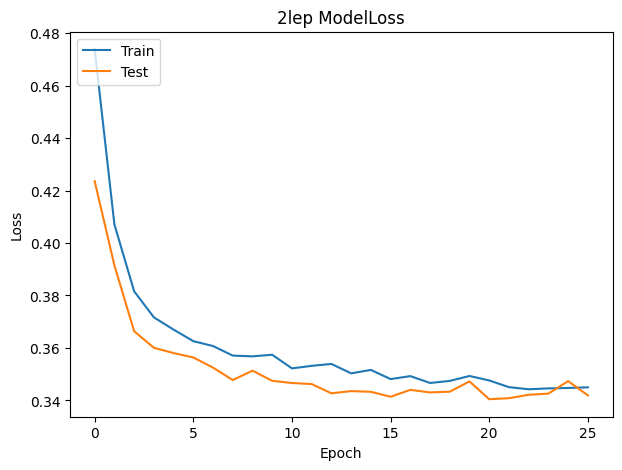

<Figure size 640x480 with 0 Axes>

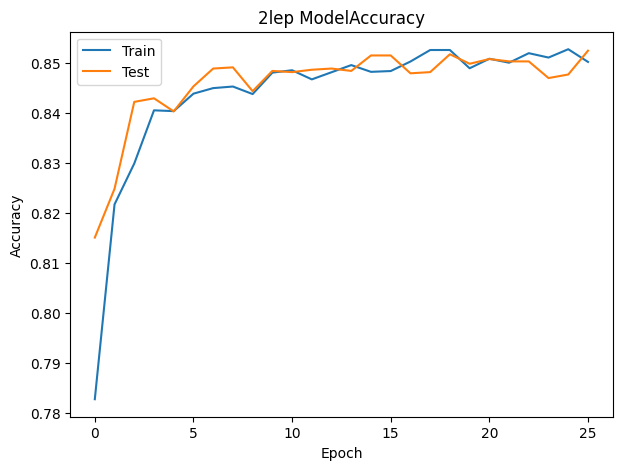

<Figure size 640x480 with 0 Axes>

In [21]:
# Plot the accuracy and loss per epoch
%matplotlib inline
import matplotlib.pyplot as plt
for i in ("loss", "accuracy"):
    plt.figure(figsize = (7, 5))
    plt.plot(history.history[i])
    plt.plot(history.history["val_" + i])
    plt.title(cut + " Model" + i.capitalize())
    plt.ylabel(i.capitalize())
    plt.xlabel("Epoch")
    plt.legend(['Train', 'Test'], loc = 'upper left')
    plt.show()
    plt.clf()

In [22]:
# Save the model
model.save("nnModels/hyperTuned" + cut + ".h5")